In [1]:
# @title
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 18px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)


# Simple Convolution Neural Network (CNN) in JAX, Flax


## What is JAX/Flax?

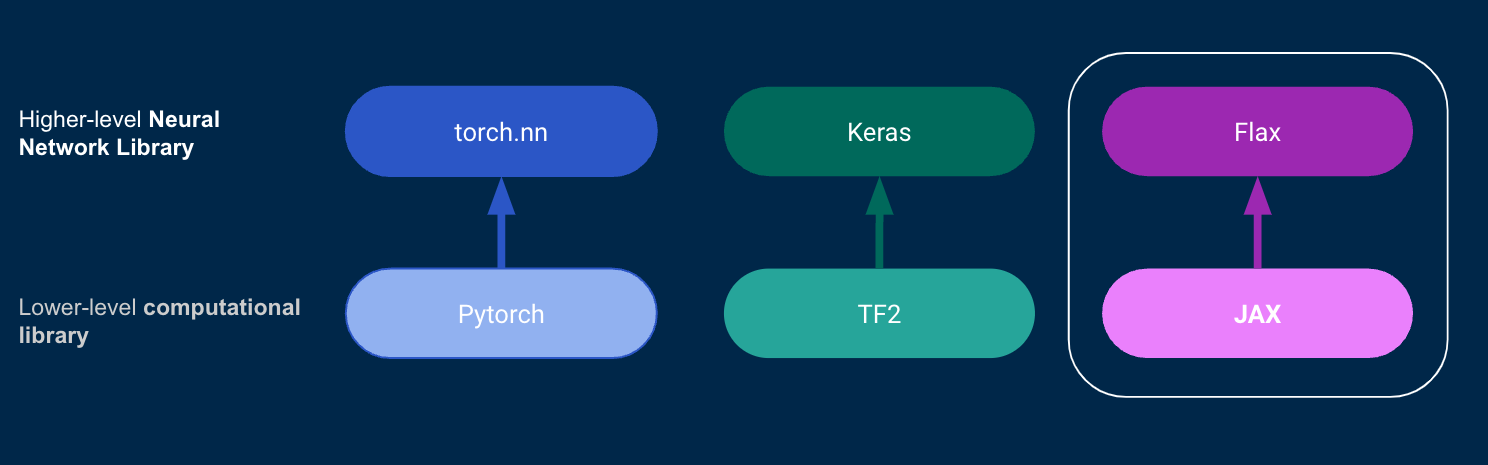

## We'll build a CNN to classify MNIST digits using JAX, Flax!

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax

## Dataset pipline

In [3]:
import tensorflow as tf

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def create_dataset(training: bool = True):
  x, y = (x_train, y_train) if training else (x_test, y_test)
  dataset = (
      tf.data.Dataset
      .from_tensor_slices((x, y))
      .shuffle(buffer_size=5000)
      .batch(64)
      .repeat()
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())
  return dataset

def get_batch(dataset):
  images, labels = next(dataset)
  images, labels = jnp.array(images), jnp.array(labels, dtype=jnp.int32)
  images = jnp.expand_dims(images, axis=-1)
  return images, labels


# Create a tf.data pipeline for the train and test set.
train_dataset = create_dataset()
test_dataset = create_dataset(training = False)

11490434/11490434 [==============================] - 1s 0us/step


### Let's test fetching a batch...

In [4]:
images_batch, labels_batch = get_batch(train_dataset)
single_image, single_label = images_batch[0], labels_batch[0]

In [5]:
single_label

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

## Modeling

In [6]:
import flax.linen as nn

class Model(nn.Module):
  def setup(self):
    # 28x28x1 -> 14x14x16
    self.conv1 =  nn.Conv(16, kernel_size=(3, 3), strides=(2, 2))

    # 14x14x16 -> 7x7x8
    self.conv2 = nn.Conv(8, kernel_size=(3, 3), strides=(2, 2))

    # 7x7x8 -> 4x4x4
    self.conv3 = nn.Conv(4, kernel_size=(3, 3), strides=(2, 2))

    # 4x4x4 -> 2x2x1
    self.conv4 = nn.Conv(1, kernel_size=(3, 3), strides=(2, 2))

    self.final_layer = nn.Dense(10)

  def __call__(self, x):
    x = nn.relu(self.conv1(x))
    x = nn.relu(self.conv2(x))
    x = nn.relu(self.conv3(x))
    x = nn.relu(self.conv4(x))

    # flatten
    batch_size = x.shape[0]
    x = x.reshape(batch_size, -1)

    x = self.final_layer(x)
    return x

## How to implement training Loop in Flax


*   ### JAX functions need to be **state-less! **
*   ### So, even the model weights need to stored and passed by our training loop code.

In [7]:
# Initialize the model using `model.init`, the function returns the model params.
model = Model()
params = model.init(jax.random.PRNGKey(99), images_batch)
params = params["params"]

In [8]:
# @title
params

{'conv1': {'kernel': Array([[[[ 0.10318059, -0.36546168,  0.10348582, -0.18727979,
            -0.2989344 , -0.06120202, -0.30305564, -0.06325838,
            -0.47007623,  0.00182239,  0.08036909, -0.28868243,
            -0.1755667 , -0.46929264,  0.22673424,  0.1213199 ]],
  
          [[-0.00159304, -0.06865791, -0.48096153,  0.5176608 ,
            -0.24610692,  0.12146369,  0.31982005,  0.19794294,
            -0.4636128 ,  0.13819885, -0.17930195,  0.1044026 ,
            -0.54910463,  0.4998827 , -0.33488676,  0.5588218 ]],
  
          [[-0.01486812, -0.27757135,  0.65702665, -0.28058687,
            -0.37632743,  0.06171224,  0.63409156,  0.1940167 ,
             0.55188036,  0.35217246, -0.39919505, -0.42158285,
            -0.2778281 , -0.01271519, -0.72809803, -0.5164525 ]]],
  
  
         [[[ 0.05771004, -0.03288956, -0.14206718, -0.3323581 ,
            -0.17923449,  0.18122466,  0.72265977,  0.53838944,
            -0.19212681,  0.2795688 , -0.23983324,  0.0612007 ,
  

# Forward Pass in JAX

### You call \`model.apply\` and explicitly pass the model weights and the current minibatch.

In [9]:
logits = model.apply({"params": params}, images_batch)

### Forward pass returns logits which are un-normalized probability over 10 classes.

In [10]:
logits.shape

(64, 10)

## creating a forward pass function...

In [11]:
# Use TrainState to store all the state required during training.

In [12]:
state = train_state.TrainState.create(
    apply_fn=model.apply,  # forward pass func
    params=params,   # model weights
    tx=optax.adam(learning_rate=0.001)  # optimizer func
)

In [13]:
def forward_pass(params, state, batch):
  input_images, labels = batch

  # call forward pass function.
  logits = state.apply_fn({"params": params}, input_images)

  # compute loss
  loss = optax.softmax_cross_entropy(logits=logits, labels=labels)
  loss = loss.mean()
  return loss, logits

# Backward Pass in JAX

In [14]:
# First, we need to create a function to compute gradients.

In [17]:
# `argnums=(0)` says differentiate wrt 0th pos argument.

grad_fn = jax.grad(forward_pass, argnums=(0), has_aux=True)

In [18]:
grads, _ = grad_fn(state.params, state, (images_batch, labels_batch))

In [19]:
# Let's look at the grads.

In [20]:
grads

{'conv1': {'bias': Array([-8.7909000e-03,  3.8306671e-03, -1.0937866e-03, -1.5936652e-03,
         -1.7949511e-04, -8.4819579e-03, -2.5967159e-03,  1.9532344e-03,
          6.2375722e-05,  1.7266974e-03, -2.3108616e-03, -9.2475570e-04,
          1.8876547e-04, -1.7713048e-03, -1.4394672e-03,  4.1070059e-03],      dtype=float32),
  'kernel': Array([[[[-2.4782396e-03,  3.5604776e-04, -3.4520621e-03,
             1.2751890e-04,  0.0000000e+00, -1.1028475e-03,
            -3.2977173e-03, -1.6332959e-05,  7.0575468e-04,
             6.5312441e-03,  1.5181347e-04,  1.4488106e-03,
             1.0416223e-04,  5.6202523e-04, -1.1956678e-03,
            -1.3143627e-04]],
  
          [[-3.7368303e-03,  3.8502470e-04, -3.4185266e-03,
             2.4682758e-04,  0.0000000e+00, -2.0101052e-03,
            -4.2646918e-03,  2.1324430e-03, -1.8709408e-04,
             4.9825571e-03,  7.1615730e-05,  1.2252905e-03,
             9.4854379e-08,  3.9522859e-04, -4.5179905e-04,
            -6.7454309e-04

In [21]:
# To apply gradients, multiply grad * learning rate and subtract from model params.

In [22]:
# But we can just use the Flax's state.apply_gradients function to do so.

In [23]:
new_state = state.apply_gradients(grads=grads)

In [25]:
new_state

TrainState(step=1, apply_fn=<bound method Module.apply of Model()>, params={'conv1': {'bias': Array([ 0.00099999, -0.00099999,  0.00099998,  0.00099999,  0.00099994,
        0.00099999,  0.00099999, -0.00099999, -0.00099983, -0.00099999,
        0.00099999,  0.00099998, -0.00099994,  0.00099999,  0.00099999,
       -0.00099999], dtype=float32), 'kernel': Array([[[[ 1.04180574e-01, -3.66461635e-01,  1.04485802e-01,
          -1.88279703e-01, -2.98934400e-01, -6.02020361e-02,
          -3.02055657e-01, -6.22589998e-02, -4.71076220e-01,
           8.22399626e-04,  7.93691650e-02, -2.89682418e-01,
          -1.76566601e-01, -4.70292628e-01,  2.27734223e-01,
           1.22319818e-01]],

        [[-5.93046541e-04, -6.96578771e-02, -4.79961544e-01,
           5.16660869e-01, -2.46106923e-01,  1.22463673e-01,
           3.20820034e-01,  1.96942955e-01, -4.62612867e-01,
           1.37198865e-01, -1.80301800e-01,  1.03402615e-01,
          -5.50009251e-01,  4.98882741e-01, -3.33886802e-01,
   

In [26]:
# putting everything together into a backward pass function...

In [41]:
def backward_pass(state, batch):
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0), has_aux=True)
  (loss, _), grads = grad_fn(state.params, state, batch)
  state = state.apply_gradients(grads=grads)
  return state, loss

In [42]:
# All training loop code code

In [43]:
def train_step(state, batch):
  return backward_pass(state, batch)

In [44]:
def eval_step(state, batch):
  _, labels = batch

  # do forward pass.
  loss, logits = forward_pass(state.params, state, batch)

  # calculate accuracy of prediction over eval dataset.
  pred_labels = jnp.argmax(nn.softmax(logits), axis=-1)

  labels = jnp.argmax(labels, axis=-1)
  acc = jnp.mean(labels == pred_labels)

  return loss, acc

In [ ]:
# Train for 1000 steps
for step in range(1000):
  train_batch = get_batch(train_dataset)

  state, loss = train_step(state, train_batch)
  if step%100==0:
    eval_batch = get_batch(test_dataset)
    eval_loss, eval_acc = eval_step(state, eval_batch)
    print("train_loss:", loss, "\teval loss:", eval_loss, "\teval acc:", eval_acc*100)

train_loss: 2.3013198 	eval loss: 2.3076892 	eval acc: 7.8125
train_loss: 2.0179853 	eval loss: 2.0544147 	eval acc: 15.625
